In [1]:
import numpy as np
import pandas as pd

from skimage import io
from skimage.filters import threshold_otsu
from skimage.morphology import binary_dilation

import os
from matplotlib import pyplot as plt
import napari
import pickle
import xarray as xr

import pydeform.sitk_api as pydeform

import morphotrack.variables
import morphotrack.points
import morphotrack.track
import morphotrack.image
import morphotrack.align
import morphotrack.nonlinear_align
# import importlib
# importlib.reload(morphotrack.track)

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [3]:
io_directory = '/mnt/ampa_data01/tmurakami/220715_prefrontal_q2_R01/morphotrack'

# load blood vessel
vessel = io.imread(os.path.join(io_directory,'R01_ch561_10um.tif'))

# load nuclei
nuclei = io.imread(os.path.join(io_directory,'R02_ch488_10um.tif'))

# load a mask of a white matter 
white_matter = io.imread(os.path.join(io_directory,'white_matter.tif'))!=0

# load a mask of a layer 1
layer1 = io.imread(os.path.join(io_directory,'l1.tif'))!=0

# segmentated tissue
segmented_tissue = io.imread(os.path.join(io_directory,'tissue_mask.tif'))!=0

# read cellular coordinate
cells_info = pd.read_csv('/mnt/ampa_data01/tmurakami/220715_prefrontal_q2_R01/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0) # the unit is original voxel.
scaling_factor = np.asarray([3,0.65,0.65])
cell_coords = cells_info.loc[:,['centroid-0','centroid-1','centroid-2']] * scaling_factor / 10# convert unit to 10 um for consistency
cell_coords = cell_coords.to_numpy()

# load track information from the previous step
track_info = xr.open_dataset(os.path.join(io_directory,"track_info.nc")).load()

In [4]:
# visual sanity check
viewer= napari.Viewer()
viewer.add_image(layer1, blending='additive')
viewer.add_image(white_matter, blending='additive')
viewer.add_image(nuclei, blending='additive')
viewer.add_image(segmented_tissue, blending='additive')

<Image layer 'segmented_tissue' at 0x7f1be757afa0>

## Count in-kernel cells

In [5]:
%%time
half_thickness = 2.5 # * 10 micrometer. half of the thickness
radius = 10 # * 10 micrometer
kernel_counts = morphotrack.points.count_around_position_in_disk_kernel(track_info.Position, cell_coords, half_thickness, radius)
kernel_counts = kernel_counts.fillna(0)

CPU times: user 6min 32s, sys: 43 s, total: 7min 15s
Wall time: 4min 38s


## Exclude tracks that are not stretch between the surface and white matter

In [18]:
# get binary mask for gray matter
gray_candidate = (1-white_matter)*segmented_tissue

# get segments where tracks are in gray matter, white matter and layer1
gray_loc = morphotrack.track.find_region(track_info.Position, gray_candidate, extract_largest=True)
white_loc = morphotrack.track.find_region(track_info.Position, white_matter)
l1_loc = morphotrack.track.find_region(track_info.Position, layer1)

# design filtering condition
filters = []

# make filter based on the size of the segment
size_threshold = 50
filters.append(gray_loc.sum(dim='time')>=size_threshold)

# make filter based on one edge is white matter
extension_param = 10
temp = gray_loc.copy()
temp.data = np.apply_along_axis(lambda a:binary_dilation(a, np.hstack([np.zeros(extension_param),np.ones(extension_param)])), axis=1, arr=gray_loc.data)
filters.append(((temp.astype(int)-gray_loc.astype(int))*white_loc).sum(dim='time')>0)

# make filter based on inclusion of layer1
filters.append(l1_loc.sum(dim='time')>0)

# dilate to obtain redundancy for alignment
gray_extension = 5
gray_loc.data = np.apply_along_axis(lambda a:binary_dilation(a, np.hstack([np.zeros(gray_extension),np.ones(gray_extension)])), axis=1, arr=gray_loc.data)

# summarize filters
filters = xr.concat(filters,dim='filt')
track_sel = filters.track[filters.all(dim='filt')]

In [19]:
# get tracks for analysis
# create a new xarray dataset with filtered tracks.
track_ds = xr.Dataset(data_vars={'Kernel_counts': kernel_counts.isel(track=track_sel), 'Gray_loc': gray_loc.isel(track=track_sel)})
track_ds['Gray_counts'] = track_ds.Kernel_counts * track_ds.Gray_loc
track_ds['Position'] = track_info.Position.isel(track=track_sel.data)
track_ds['Flow'] = track_info.Flow.isel(track=track_sel.data)
track_ds['Seeds'] = track_info.Seed.isel(track=track_sel.data)

In [61]:
# Visualize tracks in gray matter
img = morphotrack.image.visualize_in_original_space(track_ds.Position, track_ds.Gray_counts, vessel.shape)

viewer = napari.Viewer()
viewer.add_image(img,colormap='turbo',blending='additive')
viewer.add_image(nuclei,colormap='gray',blending='additive')

<Image layer 'nuclei' at 0x7f09fdc0b220>

## Alignment
### Linear alignment

In [32]:
# get a standard as a template of alignment
std_pos = morphotrack.points.pick_median_nearest_point(track_ds['Seeds'],1)
# std_pos = 1147 # or set manually
std_seed = track_ds['Seeds'][std_pos,:].track.data
standard = morphotrack.align.standard_generator(track_ds.Gray_counts,std_seed)

# linear transformation of the tracks to the standard track
args, disps = morphotrack.align.linear_shift_to_standard(track_ds.Gray_counts,std_seed)

# save to track dataset
track_ds['Standard'] = standard
track_ds['Linear_arg'] = args
track_ds['Linear_warped'] = disps

In [33]:
viewer = napari.Viewer()
viewer.add_image(track_ds.Gray_counts,colormap='green',blending='additive',visible=False)
viewer.add_image(track_ds.Standard,colormap='green',blending='additive')
viewer.add_image(track_ds.Linear_warped.sel(displacement='t2s'),colormap='magenta',blending='additive')

<Image layer 'Image [2]' at 0x7f09ff4afe50>

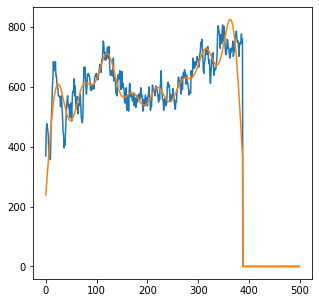

In [35]:
# check FFT filter threshold
threshold = 5e2
fig, axs = plt.subplots(figsize=(5,5))
axs.plot(track_ds.Standard.isel(track=0).data)

fft_filtered = morphotrack.nonlinear_align.filter_signal(track_ds.Standard.isel(track=0).data,threshold=threshold)
fft_filtered[track_ds.Standard.isel(track=0).data==0]=0
axs.plot(fft_filtered)

### Non-linear alignment
Finely tune the alignments by non-linear 1d registration or dynamic time warping

In [46]:
settings = {
    'pyramid_levels':3,
    'pyramid_stop_level': 0,
    'step_size': [1.0, 1.0, 1.0],
    'block_size': [512,512,512],
    'block_energy_epsilon':1e-7,
    'max_iteration_count':100,
    'constraints_weight':1000.0,
    'regularization_weight': 0.25, # default 0.25
    'regularization_scale': 1.0, # default 1.0
    'regularization_exponent': 2.0, # default 2.0
    'image_slots':[{
            'resampler': 'gaussian',
            'normalize': True,
            'cost_function':[
                {
                    'function':'ncc',
                    'weight':1.0,
                    'radius':21
                }
            ]
        }]
}

In [47]:
# non-linear transformation of the tracks to the standard track
non_linear_args = morphotrack.nonlinear_align.track_wise_aligner(
    track_ds.Standard.data, 
    track_ds.Linear_warped.sel(displacement='t2s').data,
    fft_threshold=threshold, 
    settings=settings# morphotrack.variables.settings
)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 2863/2863 [04:26<00:00, 10.76it/s]


In [48]:
# store non linear displacement in xarray
non_linear_arg_xr = track_ds.Linear_arg.copy()
non_linear_arg_xr[:] = np.asarray(non_linear_args[::-1])
track_ds['Nonlinear_arg'] = non_linear_arg_xr

# make total displacement 
comp_disps = []
for x in track_ds.Nonlinear_arg.displacement.data:
    comp_disps.append(morphotrack.align.composite_displacement(track_ds.Linear_arg.sel(displacement=x),track_ds.Nonlinear_arg.sel(displacement=x)))

# store total displacement in xarray
total_arg_xr = track_ds.Linear_arg.copy()
total_arg_xr[:] = np.asarray(comp_disps)
track_ds['Total_arg'] = total_arg_xr

# make total warped tracks
s2t_non_linear_warped = morphotrack.align.positional_mapping(track_ds.Standard, track_ds.Total_arg.sel(displacement='s2t'))
t2s_non_linear_warped = morphotrack.align.positional_mapping(track_ds.Gray_counts, track_ds.Total_arg.sel(displacement='t2s'))

# store total warp in xarray
total_warp_xr = track_ds.Linear_arg.copy()
total_warp_xr[:] = np.asarray([s2t_non_linear_warped, t2s_non_linear_warped])
track_ds['Total_warped'] = total_warp_xr

In [49]:
# visual quality check
viewer = napari.Viewer()
viewer.add_image(track_ds.Gray_counts,colormap='green',blending='additive',visible=False)
viewer.add_image(track_ds.Standard,colormap='green',blending='additive')
viewer.add_image(track_ds.Total_warped.sel(displacement='t2s'),colormap='magenta',blending='additive')
viewer.add_image(track_ds.Total_warped.sel(displacement='s2t'),colormap='magenta',blending='additive',visible=False)

<Image layer 'Image [3]' at 0x7f09fe840bb0>

In [59]:
# visual quality check in the original space
img = morphotrack.image.visualize_in_original_space(track_ds.Position, track_ds.Total_arg.sel(displacement='s2t'), vessel.shape)

viewer = napari.Viewer()
viewer.add_image(img,colormap='turbo',blending='additive')
viewer.add_image(nuclei,colormap='gray',blending='additive')

<Image layer 'nuclei' at 0x7f09fd9489d0>

In [60]:
track_ds.to_netcdf(os.path.join(io_directory,"track_alignment.nc"))